In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from kepler_func import *
from IPython.core.display import display, HTML

display(HTML('''
<style>
.output_scroll {
    overflow-x: auto !important;
    overflow-y: visible !important;
    max-height: none !important;
}
</style>
'''))

%matplotlib inline


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/var/folders/d2/967f_3k57458fwy_1s1dh8_w0000gn/T/ipykernel_89636/2998155965.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Get some data from NASA Horizons

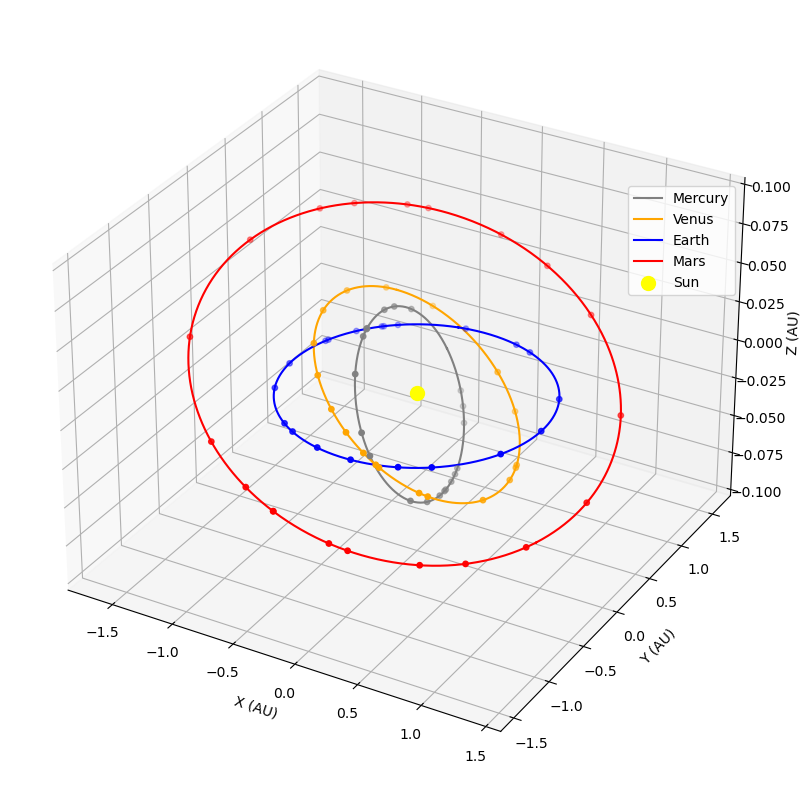

In [2]:
# Define planet IDs
planets = {
    'Mercury': 199,
    'Venus': 299,
    'Earth': 399,
    'Mars': 499
}

colors = {
        'Mercury': 'gray',
        'Venus': 'orange',
        'Earth': 'blue',
        'Mars': 'red'
    }

# Define epoch for orbital elements (Julian Date for 2021-Jan-01)
epoch = {'start': '2008-01-06', 'stop': '2009-01-06', 'step': '30d'}
# Define observation time range
obs_epochs = {'start': '1993-01-01', 'stop': '2023-01-01', 'step': '30d'}


orbitalObs_df, orbitalParams_df, true_anomaly_values_df = get_orbital_observations(planets, epoch, obs_epochs)

#print(true_anomaly_values_df.head())
#print(orbitalParams_df.head())
#print(orbitalObs_df.head())

In [3]:
# Initialize plot
#different_plots(planets, true_anomaly_values_df, orbitalObs_df)

In [4]:
# plot planets before and after transformation to Perifocal frame:
#perifocal_trans_plot(planets, orbitalObs_df, orbitalParams_df)

Run IRAS on Mercury coordinates:

In [5]:
enableIRAS_train = False
if enableIRAS_train:
    IRAS_runOnCoordinatesResultsDict = dict()
    IRAS_runOnCoordinatesResultsDict['Mercury'] = runIRAS_onCoordinates('Mercury', true_anomaly_values_df, orbitalObs_df, orbitalParams_df)
    
    
    with open('/Users/ron.teichner/Library/CloudStorage/OneDrive-Technion/Kepler/IRAS_results.pkl', 'wb') as file:
        pickle.dump(IRAS_runOnCoordinatesResultsDict, file)


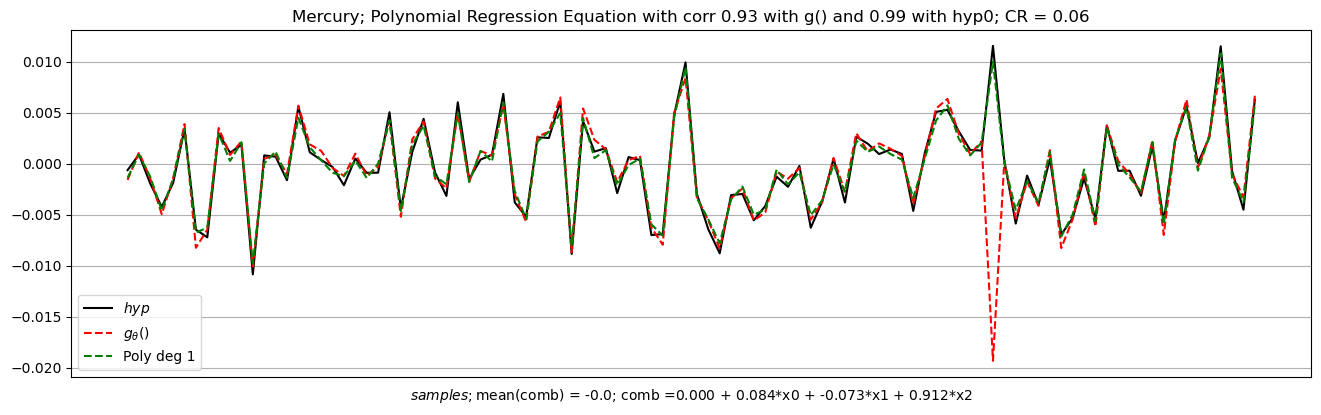

Mercury; GT plane eq: 0=0.000 + 0.091*x + -0.081*y + 0.993*z; IRAS-polyFit eq: 0=0.001 + 0.092*x + -0.079*y + 0.993*z; angle between normals is 0.1292 deg
sanity orbital plane eq: 0=[ 0.          0.09108063 -0.08108878  0.99253661]


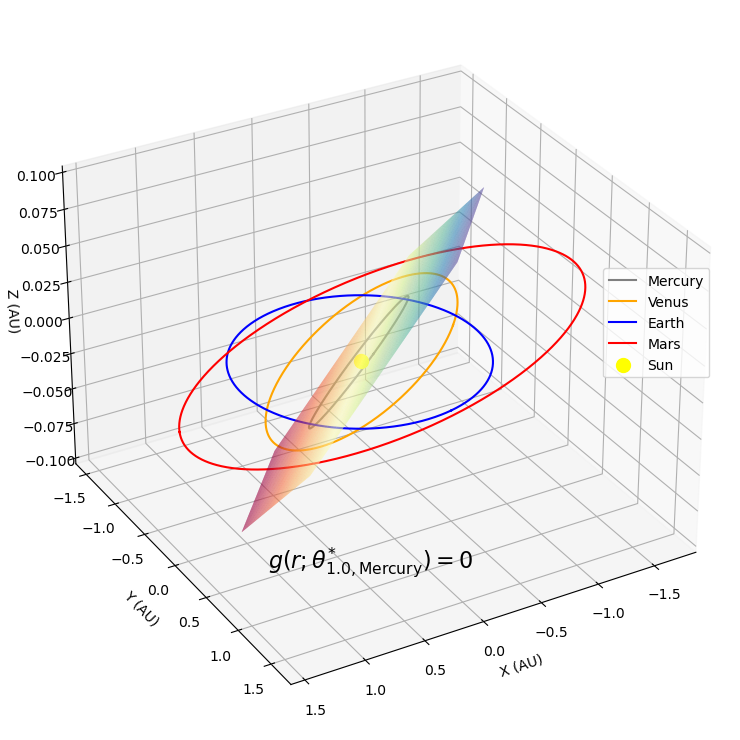

In [6]:
IRAS_runOnCoordinatesResultsDict = pickle.load(open('/Users/ron.teichner/Library/CloudStorage/OneDrive-Technion/Kepler/IRAS_results.pkl', 'rb'))

highScoreHyp = get_highScoreHyp(IRAS_runOnCoordinatesResultsDict['Mercury'])
print_IRAS_res(IRAS_runOnCoordinatesResultsDict['Mercury'], highScoreHyp)
plot_manifold(IRAS_runOnCoordinatesResultsDict['Mercury'], highScoreHyp, true_anomaly_values_df, orbitalObs_df, orbitalParams_df, title3D=r'$g(r;\theta^{*}_{1.0,\mathrm{Mercury}})=0$')

In [7]:
orbitalParams_df['est_orbitalPlaneNormal'] = orbitalParams_df.apply(lambda row: add_est_orbitalPlaneNormal(row, 'Mercury', IRAS_runOnCoordinatesResultsDict['Mercury']['implicitPolyDictList'][0]['coefficients'][1:][:,None], 'est_orbitalPlaneNormal'), axis=1)
orbitalObs_df['r_proj2EstOrbitalPlane'] = orbitalObs_df.apply(lambda row: proj_r_2EstOrbitalPlane(row, orbitalParams_df), axis=1)
orbitalObs_df['r_2D_est'] = orbitalObs_df.apply(lambda row: transform_2_2D(row, orbitalParams_df, np.array([[1], [0], [0]]), True), axis=1)
alpha = 1e-1
orbitalObs_df['r_2D_est_noisy'] = orbitalObs_df.apply(lambda row: convert_to_r(row, orbitalObs_df, orbitalParams_df, alpha, workOn2D_est=True), axis=1)

/Users/ron.teichner/Projects/IRAS/kepler_func.py:247: RuntimeWarning: invalid value encountered in divide
  return r - (n.T@r / np.power(np.linalg.norm(n), 2)) * n
/Users/ron.teichner/Projects/IRAS/kepler_func.py:201: RuntimeWarning: invalid value encountered in divide
  u = (np.cross(normal[:,0],a[:,0]) / np.linalg.norm(np.cross(normal[:,0],a[:,0])))[:,None]


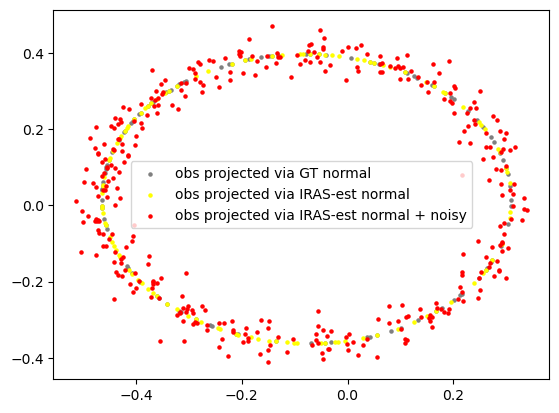

In [8]:
Obs = orbitalObs_df[orbitalObs_df['target'] == 'Mercury']

alpha = np.asarray([Obs['r_2D'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
beta = np.asarray([Obs['r_2D'].to_numpy()[i][1,0] for i in range(Obs.shape[0])])

alpha_hat = np.asarray([Obs['r_2D_est'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
beta_hat = np.asarray([Obs['r_2D_est'].to_numpy()[i][1,0] for i in range(Obs.shape[0])])

alpha_hat_noisy = np.asarray([Obs['r_2D_est_noisy'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
beta_hat_noisy = np.asarray([Obs['r_2D_est_noisy'].to_numpy()[i][1,0] for i in range(Obs.shape[0])])

plt.figure()
indices = np.random.permutation(np.arange(len(alpha_hat)))[:int(0.3*len(alpha_hat))]
plt.scatter(x=alpha[indices], y=beta[indices], s=5, color=colors['Mercury'], label='obs projected via GT normal')
indices = np.random.permutation(np.arange(len(alpha_hat)))[:int(0.3*len(alpha_hat))]
plt.scatter(x=alpha_hat[indices], y=beta_hat[indices], s=5, color='yellow', label='obs projected via IRAS-est normal')
indices = np.random.permutation(np.arange(len(alpha_hat)))
plt.scatter(x=alpha_hat_noisy[indices], y=beta_hat_noisy[indices], s=5, color='red', label='obs projected via IRAS-est normal + noisy')
plt.legend()
plt.show()

epoch 122 nMSE = 0.010377
Polynomial Regression Equation with corr 0.97:
mean(y) = 0.0; y = 5.552 + -3.949*x0 + 0.980*x1 + -32.878*x0^2 + -3.388*x0 x1 + -43.102*x1^2


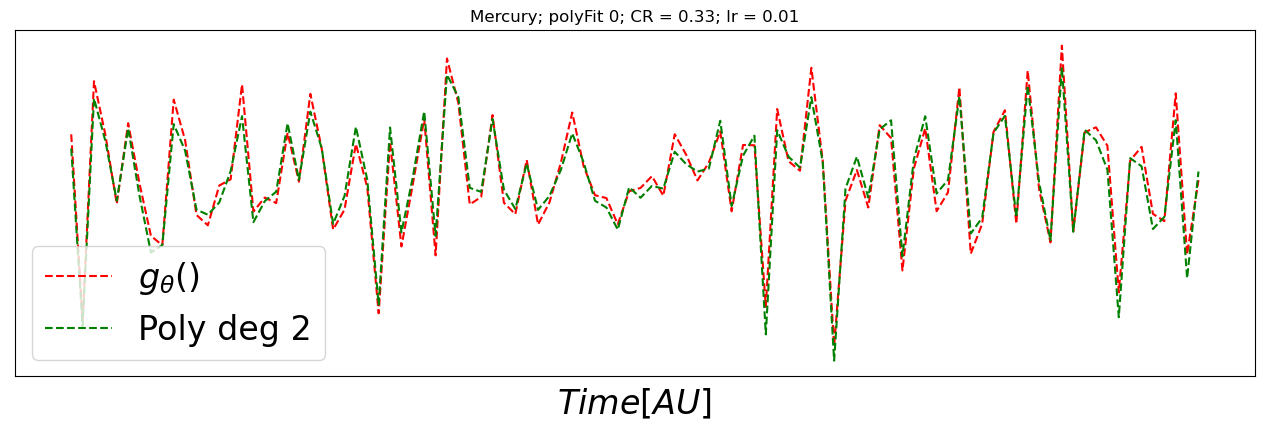

validation. nativeIRAS Adam epoch 122: %Selected = 21, CR(zeta=1) = 0.331, CR = 1.012, ; 


In [ ]:
IRAS_runOnCoordinatesResultsDict['Mercury2D'] = runIRAS_onCoordinates('Mercury', true_anomaly_values_df, orbitalObs_df, orbitalParams_df, runOn2D=True, externalReport=True)


with open('/Users/ron.teichner/Library/CloudStorage/OneDrive-Technion/Kepler/IRAS_results.pkl', 'wb') as file:
    pickle.dump(IRAS_runOnCoordinatesResultsDict, file)


In [ ]:
print(f"{len(IRAS_runOnCoordinatesResultsDict['Mercury2D']['implicitPolyDictList'])}")
IRAS_runOnCoordinatesResultsDict['Mercury2D']['implicitPolyDictList'][0]['ellipse_fit']

In [ ]:
ellipse_params = IRAS_runOnCoordinatesResultsDict['Mercury2D']['implicitPolyDictList'][0]['ellipse_fit']['ellipse_params']

A, B, C, h, k = ellipse_params['A'], ellipse_params['B'], ellipse_params['C'], ellipse_params['h'], ellipse_params['k']

# Create a grid of x and y values
x_vals = np.linspace(h - 5, h + 5, 400)
y_vals = np.linspace(k - 5, k + 5, 400)
X, Y = np.meshgrid(x_vals, y_vals)

# Compute the left-hand side of the ellipse equation
Z = A * (X - h)**2 + B * (X - h) * (Y - k) + C * (Y - k)**2

# Plot the contour where the equation equals 1
plt.contour(X, Y, Z, levels=[1], colors='blue', label='fitted ellipse for IRAS g()')
plt.title("Ellipse: A(x−h)^2 + B(x−h)(y−k) + C(y−k)^2 = 1")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)

Obs = orbitalObs_df[orbitalObs_df['target'] == 'Mercury']
alpha = np.asarray([Obs['r_2D'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
beta = np.asarray([Obs['r_2D'].to_numpy()[i][1,0] for i in range(Obs.shape[0])])
alpha_hat = np.asarray([Obs['r_2D_est'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
beta_hat = np.asarray([Obs['r_2D_est'].to_numpy()[i][1,0] for i in range(Obs.shape[0])])
indices = np.random.permutation(np.arange(len(alpha_hat)))
plt.scatter(x=alpha_hat[indices], y=beta_hat[indices], s=5, color='yellow', label='obs projected via IRAS-est normal')
plt.legend()
plt.xlim([-0.5, 0.5])
plt.ylim([-0.5, 0.5])
plt.show()


In [ ]:
IRAS_runOnCoordinatesResults = IRAS_runOnCoordinatesResultsList[1]
highScoreHyp = get_highScoreHyp(IRAS_runOnCoordinatesResults)
print_IRAS_res(IRAS_runOnCoordinatesResults['implicitPolyDictList'][highScoreHyp], IRAS_runOnCoordinatesResults, highScoreHyp)
plot_manifold(IRAS_runOnCoordinatesSinglePlanetResultsDict['implicitPolyDictList'][highScoreHyp], IRAS_runOnCoordinatesSinglePlanetResultsDict['degreeOfPolyFit'][highScoreHyp], IRAS_runOnCoordinatesSinglePlanetResultsDict, true_anomaly_values_df, orbitalObs_df, orbitalParams_df)

In [ ]:
IRAS_runOnCoordinatesResults = IRAS_runOnCoordinatesResultsList[2]
highScoreHyp = get_highScoreHyp(IRAS_runOnCoordinatesResults)
print_IRAS_res(IRAS_runOnCoordinatesResults['implicitPolyDictList'][highScoreHyp], IRAS_runOnCoordinatesResults, highScoreHyp)
plot_manifold(IRAS_runOnCoordinatesSinglePlanetResultsDict['implicitPolyDictList'][highScoreHyp], IRAS_runOnCoordinatesSinglePlanetResultsDict['degreeOfPolyFit'][highScoreHyp], IRAS_runOnCoordinatesSinglePlanetResultsDict, true_anomaly_values_df, orbitalObs_df, orbitalParams_df)

In [ ]:
IRAS_runOnCoordinatesResults = IRAS_runOnCoordinatesResultsList[3]
highScoreHyp = get_highScoreHyp(IRAS_runOnCoordinatesResults)
print_IRAS_res(IRAS_runOnCoordinatesResults['implicitPolyDictList'][highScoreHyp], IRAS_runOnCoordinatesResults, highScoreHyp)
plot_manifold(IRAS_runOnCoordinatesSinglePlanetResultsDict['implicitPolyDictList'][highScoreHyp], IRAS_runOnCoordinatesSinglePlanetResultsDict['degreeOfPolyFit'][highScoreHyp], IRAS_runOnCoordinatesSinglePlanetResultsDict, true_anomaly_values_df, orbitalObs_df, orbitalParams_df)

In [ ]:
# IRAS_train_script(observations, observations_tVec, hypotheses_regulations, titleStr='', nativeIRAS=True)
# with observations having shape of (N x T x F) and observations_tVec (N x T x 1). 
# Here N is the number of observed timeseries, T is the number of samples in each timeseries and F the number of observables. 
# The observations are in the variable observations and their corresponding times in observations_tVec. 
# In the input V the user can place an hypothesis. 
# The Pearson correlation between the hypothesis and the output of the algorithm is printed and their figure is plotted.
#   playerPerPatient = False

In [8]:
coeffs = IRAS_runOnCoordinatesResultsDict['Mercury']['implicitPolyDictList'][0]['coefficients']
intercept = IRAS_runOnCoordinatesResultsDict['Mercury']['implicitPolyDictList'][0]['intercept']

In [14]:
coeffs

array([ 0.        ,  0.08445503, -0.07257847,  0.9118974 ], dtype=float32)

In [21]:
planet = 'Mercury'
OrbitParams = orbitalParams_df[orbitalParams_df['target'] == planet]
[0, OrbitParams['rotation_matrix'].to_numpy()[0][0,2], OrbitParams['rotation_matrix'].to_numpy()[0][1,2], OrbitParams['rotation_matrix'].to_numpy()[0][2,2]]

[0, 0.09108063431352488, -0.08108877594292728, 0.9925366131630227]